# Análisis de Redes de Co-ocurrencia en Playlists de Spotify
# Proyecto de Minería de Grafos

## 1. Introducción y Objetivo

# Análisis de Redes de Co-ocurrencia en Playlists de Spotify

## Objetivo
Este notebook implementa un análisis completo de redes complejas basado en datos reales de Spotify,
enfocándose en la co-ocurrencia de canciones en playlists públicas. Utilizamos técnicas de teoría
de grafos para identificar patrones musicales, comunidades temáticas y canciones clave en el ecosistema musical.

## Preguntas de Investigación
- ¿Cuáles son los patrones de co-ocurrencia entre canciones en playlists?
- ¿Qué canciones actúan como "puentes" conectando diferentes géneros/estilos?
- ¿Existen comunidades musicales claramente definidas?
- ¿Cómo varía la estructura de la red según diferentes criterios?

## Metodología
Construiremos una red no dirigida donde cada nodo representa una canción única y las aristas
representan co-ocurrencias en playlists, con pesos según la frecuencia de co-aparición.
"""


In [ ]:
!pip install spotipy pandas
!pip install python-dotenv
!pip install networkx plotly community-detection python-louvain scikit-learn -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 18.5 MB/s eta 0:00:00


## Creacion del dataset - API Spotify

In [ ]:
# ============================================
# ⏱️ Inicializador de tiempo por celda
# ============================================
import time
from IPython.display import display, Markdown

# Decorador para medir y mostrar duración de funciones
def timed_section(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        duration = time.time() - start
        display(Markdown(f"⏱️ **Duración:** `{duration:.2f}` segundos"))
        return result
    return wrapper


In [ ]:
import requests
import base64
import csv
import time

class SpotifyPlaylistGetter:
    def __init__(self, client_id, client_secret):
        self.client_id = client_id
        self.client_secret = client_secret
        self.access_token = None
        self.base_url = "https://api.spotify.com/v1"

    def get_access_token(self):
        credentials = f"{self.client_id}:{self.client_secret}"
        credentials_base64 = base64.b64encode(credentials.encode()).decode()

        response = requests.post("https://accounts.spotify.com/api/token",
                               headers={"Authorization": f"Basic {credentials_base64}"},
                               data={"grant_type": "client_credentials"})

        if response.status_code == 200:
            self.access_token = response.json()["access_token"]
            return True
        return False

    def get_playlist_tracks(self, playlist_id):
        """Obtiene todas las canciones de una playlist"""
        headers = {"Authorization": f"Bearer {self.access_token}"}
        tracks = []
        offset = 0
        limit = 100

        while True:
            url = f"{self.base_url}/playlists/{playlist_id}/tracks"
            params = {"offset": offset, "limit": limit}

            response = requests.get(url, headers=headers, params=params)

            if response.status_code != 200:
                break

            data = response.json()
            items = data.get("items", [])

            if not items:
                break

            tracks.extend(items)
            offset += limit

            if len(items) < limit:
                break

        return tracks

    def get_playlist_info(self, playlist_id):
        """Obtiene información básica de la playlist"""
        headers = {"Authorization": f"Bearer {self.access_token}"}
        url = f"{self.base_url}/playlists/{playlist_id}"

        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            data = response.json()
            return {
                "name": data.get("name", ""),
                "description": data.get("description", ""),
                "followers": data.get("followers", {}).get("total", 0),
                "owner": data.get("owner", {}).get("display_name", "")
            }
        return None

    def extract_playlist_id(self, url):
        """Extrae el ID de la playlist desde la URL"""
        if "playlist/" in url:
            return url.split("playlist/")[1].split("?")[0]
        return None

    def process_playlists_to_csv(self, playlist_urls, output_file="spotify_playlists_data.csv"):
        """Procesa las playlists y genera un CSV con los datos"""

        # Crear archivo CSV
        with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
            fieldnames = [
                'playlist_id', 'playlist_name', 'playlist_description',
                'playlist_followers', 'playlist_owner', 'track_id',
                'track_name', 'artist_name', 'album_name', 'duration_ms',
                'popularity', 'explicit', 'track_position'
            ]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()

            total_playlists = len(playlist_urls)
            processed = 0

            for url in playlist_urls:
                playlist_id = self.extract_playlist_id(url)
                if not playlist_id:
                    continue

                print(f"Procesando playlist {processed+1}/{total_playlists}: {playlist_id}")

                # Obtener info de la playlist
                playlist_info = self.get_playlist_info(playlist_id)
                if not playlist_info:
                    print(f"  Error obteniendo info de playlist {playlist_id}")
                    continue

                # Obtener tracks de la playlist
                tracks = self.get_playlist_tracks(playlist_id)
                print(f"  Encontradas {len(tracks)} canciones")

                # Escribir cada canción al CSV
                for position, item in enumerate(tracks, 1):
                    track = item.get("track")
                    if not track or track.get("type") != "track":
                        continue

                    # Obtener artistas
                    artists = track.get("artists", [])
                    artist_names = ", ".join([artist.get("name", "") for artist in artists])

                    # Escribir fila
                    writer.writerow({
                        'playlist_id': playlist_id,
                        'playlist_name': playlist_info["name"],
                        'playlist_description': playlist_info["description"],
                        'playlist_followers': playlist_info["followers"],
                        'playlist_owner': playlist_info["owner"],
                        'track_id': track.get("id", ""),
                        'track_name': track.get("name", ""),
                        'artist_name': artist_names,
                        'album_name': track.get("album", {}).get("name", ""),
                        'duration_ms': track.get("duration_ms", 0),
                        'popularity': track.get("popularity", 0),
                        'explicit': track.get("explicit", False),
                        'track_position': position
                    })

                processed += 1

                # Pequeña pausa para no sobrecargar la API
                time.sleep(0.1)

        print(f"\n✅ CSV generado: {output_file}")
        print(f"📊 Procesadas {processed} playlists")

def main():
    CLIENT_ID = "337ea541e00f4c66a8ab00359d8e1484"
    CLIENT_SECRET = "1eace782af1f40ffb84b403275d621c6"

    if CLIENT_ID == "tu_client_id_aqui":
        print("❌ Configura tus credenciales")
        return

    spotify = SpotifyPlaylistGetter(CLIENT_ID, CLIENT_SECRET)

    if not spotify.get_access_token():
        print("❌ Error de autenticación")
        return

    print("✅ Conectado a Spotify")

    # Obtener enlaces de ejemplo (puedes cargar desde archivo)
    search_terms = ["rock", "pop", "hip hop", "electronic", "jazz"]

    print("🔍 Buscando playlists...")
    playlist_urls = []

    for term in search_terms:
        headers = {"Authorization": f"Bearer {spotify.access_token}"}
        params = {"q": term, "type": "playlist", "limit": 20}

        response = requests.get(f"{spotify.base_url}/search", headers=headers, params=params)

        if response.status_code == 200:
            playlists = response.json().get("playlists", {}).get("items", [])
            for playlist in playlists:
                if playlist:
                    playlist_urls.append(playlist["external_urls"]["spotify"])

    # Eliminar duplicados y limitar
    unique_urls = list(set(playlist_urls))[:50]  # Limitar a 50 para prueba

    print(f"📋 Procesando {len(unique_urls)} playlists...")

    # Procesar playlists y generar CSV
    spotify.process_playlists_to_csv(unique_urls)

if __name__ == "__main__":
    main()

✅ Conectado a Spotify
🔍 Buscando playlists...
📋 Procesando 38 playlists...
Procesando playlist 1/38: 1ti3v0lLrJ4KhSTuxt4loZ
  Encontradas 708 canciones
Procesando playlist 2/38: 5vVSfOsF8YRueAI1dOI0Lh
  Encontradas 211 canciones
Procesando playlist 3/38: 04C2Ck8ZTVTBn54mOyaXuW
  Encontradas 92 canciones
Procesando playlist 4/38: 26MY3qVKQFBSqNMBshJZs8
  Encontradas 117 canciones
Procesando playlist 5/38: 62y3BHKehWnb1hlaPclDAA
  Encontradas 487 canciones
Procesando playlist 6/38: 4fg5ZG6JPgVEWwf4yN8mST
  Encontradas 2560 canciones
Procesando playlist 7/38: 6vDGVr652ztNWKZuHvsFvx
  Encontradas 151 canciones
Procesando playlist 8/38: 26Zi3qLKC9cAWDs7wbbSzc
  Encontradas 180 canciones
Procesando playlist 9/38: 5mMwgU3jW7Wxxkr5F7GzSj
  Encontradas 150 canciones
Procesando playlist 10/38: 0dMexqq0XIWS3QJ74z3ZhD
  Encontradas 150 canciones
Procesando playlist 11/38: 1IGF7xoNwjg3FnNZTmT5XU
  Encontradas 4685 canciones
Procesando playlist 12/38: 4SAKvm9HtIV3HwVQeAWBD1
  Encontradas 82 cancione

## Instalación de Dependencias y Configuración

In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter, defaultdict
import community as community_louvain
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
print("✅ Librerías importadas correctamente")
print("📊 Configuración de visualización establecida")

✅ Librerías importadas correctamente
📊 Configuración de visualización establecida


## Exploracion del Datastet

In [ ]:
## 3. Carga y Exploración del Dataset

def load_and_explore_data(filename='spotify_playlists_data.csv'):
    """
    Carga y explora el dataset de Spotify

    Args:
        filename (str): Nombre del archivo CSV

    Returns:
        pd.DataFrame: Dataset cargado
    """
    print("🔄 Cargando dataset de Spotify...")

    try:
        df = pd.read_csv(filename)
        print(f"✅ Dataset cargado exitosamente")
        print(f"📏 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")

        # Exploración básica
        print(f"\n📋 Información del Dataset:")
        print(f"• Número de playlists únicas: {df['playlist_id'].nunique()}")
        print(f"• Número de canciones únicas: {df['track_id'].nunique()}")
        print(f"• Número de artistas únicos: {df.get('artist_name', df.get('artists', pd.Series())).nunique()}")

        print(f"\n🔍 Primeras 5 filas:")
        display(df.head())

        print(f"\n📊 Información de columnas:")
        print(df.info())

        return df

    except Exception as e:
        print(f"❌ Error al cargar el dataset: {e}")
        return None

# Cargar datos
df = load_and_explore_data()



🔄 Cargando dataset de Spotify...
✅ Dataset cargado exitosamente
📏 Dimensiones: 15481 filas × 13 columnas

📋 Información del Dataset:
• Número de playlists únicas: 38
• Número de canciones únicas: 14445
• Número de artistas únicos: 8212

🔍 Primeras 5 filas:


,playlist_id,playlist_name,playlist_description,playlist_followers,playlist_owner,track_id,track_name,artist_name,album_name,duration_ms,popularity,explicit,track_position
0,1ti3v0lLrJ4KhSTuxt4loZ,Top Classic Rock Hits Of All Time,NaN,131521,Tom Schumacher,0LN0ASTtcGIbNTnjSHG6eO,Pour Some Sugar On Me (2012),Def Leppard,Pour Some Sugar On Me (2012),261532,0,False,1
1,1ti3v0lLrJ4KhSTuxt4loZ,Top Classic Rock Hits Of All Time,NaN,131521,Tom Schumacher,2zYzyRzz6pRmhPzyfMEC8s,Highway to Hell,AC/DC,Highway to Hell,208400,88,False,2
2,1ti3v0lLrJ4KhSTuxt4loZ,Top Classic Rock Hits Of All Time,NaN,131521,Tom Schumacher,0J6mQxEZnlRt9ymzFntA6z,Livin' On A Prayer,Bon Jovi,Slippery When Wet,249293,8,False,3
3,1ti3v0lLrJ4KhSTuxt4loZ,Top Classic Rock Hits Of All Time,NaN,131521,Tom Schumacher,4bHsxqR3GMrXTxEPLuK5ue,Don't Stop Believin',Journey,Escape (Bonus Track Version),250986,18,False,4
4,1ti3v0lLrJ4KhSTuxt4loZ,Top Classic Rock Hits Of All Time,NaN,131521,Tom Schumacher,7tFiyTwD0nx5a1eklYtX2J,Bohemian Rhapsody - Remastered 2011,Queen,A Night At The Opera (Deluxe Remastered Version),354320,77,False,5



📊 Información de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15481 entries, 0 to 15480
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   playlist_id           15481 non-null  object
 1   playlist_name         15481 non-null  object
 2   playlist_description  8744 non-null   object
 3   playlist_followers    15481 non-null  int64 
 4   playlist_owner        15481 non-null  object
 5   track_id              15481 non-null  object
 6   track_name            15480 non-null  object
 7   artist_name           15480 non-null  object
 8   album_name            15480 non-null  object
 9   duration_ms           15481 non-null  int64 
 10  popularity            15481 non-null  int64 
 11  explicit              15481 non-null  bool  
 12  track_position        15481 non-null  int64 
dtypes: bool(1), int64(4), object(8)
memory usage: 1.4+ MB
None


## Construcción de la Red de Co-ocurrencia

In [ ]:
# ============================================
# 4. Construcción de la Red de Co-ocurrencia
# ============================================

import networkx as nx
import pandas as pd
import numpy as np
from collections import defaultdict

@timed_section
def build_cooccurrence_network(df, track_col='track_id', playlist_col='playlist_id'):
    """
    Construye una red de co-ocurrencia de canciones basada en playlists compartidas.

    Args:
        df (pd.DataFrame): Dataset con información de playlists y tracks
        track_col (str): Nombre de la columna de track ID
        playlist_col (str): Nombre de la columna de playlist ID

    Returns:
        nx.Graph: Grafo de co-ocurrencia
    """
    print("🏗️ Construyendo red de co-ocurrencia...")

    # Crear diccionario: playlist_id -> conjunto de canciones
    playlist_tracks = defaultdict(set)
    for _, row in df.iterrows():
        if pd.notna(row[track_col]):
            playlist_tracks[row[playlist_col]].add(str(row[track_col]))

    # Inicializar grafo no dirigido
    G = nx.Graph()

    # Agregar todos los nodos únicos (canciones)
    all_tracks = df[track_col].dropna().unique()
    G.add_nodes_from(all_tracks.astype(str))

    # Diccionario para contar co-ocurrencias entre pares de canciones
    cooccurrence_count = defaultdict(int)

    print("🔄 Calculando co-ocurrencias entre canciones...")
    for playlist_id, tracks in playlist_tracks.items():
        tracks_list = list(tracks)
        for i in range(len(tracks_list)):
            for j in range(i + 1, len(tracks_list)):
                track1, track2 = tracks_list[i], tracks_list[j]
                edge = tuple(sorted([track1, track2]))
                cooccurrence_count[edge] += 1

    print("🔗 Agregando aristas con pesos al grafo...")
    for (track1, track2), weight in cooccurrence_count.items():
        G.add_edge(track1, track2, weight=weight)

    # Imprimir estadísticas de la red
    print("\n📊 Estadísticas de la Red:")
    print(f"• Nodos (canciones): {G.number_of_nodes():,}")
    print(f"• Aristas (co-ocurrencias): {G.number_of_edges():,}")
    print(f"• Densidad: {nx.density(G):.6f}")

    weights = [d['weight'] for _, _, d in G.edges(data=True)]
    print(f"• Peso promedio de aristas: {np.mean(weights):.2f}")
    print(f"• Peso máximo: {max(weights)}")
    print(f"• Peso mínimo: {min(weights)}")

    return G

# Ejecutar la construcción
G = build_cooccurrence_network(df)

# Guardar el grafo
@timed_section
def save_graph(G, filename="spotify_cooccurrence_network.gml"):
    """
    Guarda el grafo en formato GML.
    """
    print("\n💾 Guardando grafo...")
    nx.write_gml(G, filename)
    print(f"✅ Grafo guardado como '{filename}'")

save_graph(G)


🏗️ Construyendo red de co-ocurrencia...
🔄 Calculando co-ocurrencias entre canciones...
🔗 Agregando aristas con pesos al grafo...

📊 Estadísticas de la Red:
• Nodos (canciones): 14,445
• Aristas (co-ocurrencias): 15,717,669
• Densidad: 0.150665
• Peso promedio de aristas: 1.00
• Peso máximo: 5
• Peso mínimo: 1


⏱️ **Duración:** `74.63` segundos


💾 Guardando grafo...
✅ Grafo guardado como 'spotify_cooccurrence_network.gml'


⏱️ **Duración:** `82.62` segundos

> Se construyó un grafo no dirigido donde los nodos representan canciones y las aristas indican co-ocurrencia en una misma playlist. El peso de cada arista corresponde al número de playlists compartidas. La red final contiene 10,233 nodos y más de 6.5 millones de aristas, lo que indica un alto nivel de interconexión musical. La densidad fue de 0.125 y se guardó la red en formato GML.



In [ ]:
pip install pyvis networkx pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.3 MB/s eta 0:00:00


In [ ]:
import networkx as nx
from pyvis.network import Network
import pandas as pd

# 1. Cargar el grafo desde el archivo GML
G = nx.read_gml("spotify_cooccurrence_network.gml")

# 2. Preparar datos adicionales (asumiendo que tienes un CSV con metadatos)
# Si no tienes esto, puedes saltar este paso
try:
    df = pd.read_csv("spotify_playlists_data.csv")
    track_info = df.set_index('track_id').to_dict('index')
except:
    track_info = {}

# 3. Configurar el grafo interactivo
net = Network(
    height="800px",
    width="100%",
    bgcolor="#222222",
    font_color="white",
    select_menu=True,  # Habilitar menú de selección
    filter_menu=True,   # Habilitar filtros
    cdn_resources='in_line'  # Para funcionar offline
)

# 4. Añadir nodos y aristas con atributos
for node in G.nodes():
    # Obtener metadatos si existen
    name = track_info.get(node, {}).get('track_name', node)
    artist = track_info.get(node, {}).get('artist_name', 'Artista desconocido')

    net.add_node(
        node,
        label=name[:30] + "...",  # Limitar longitud de etiqueta
        title=f"{name}<br>Artista: {artist}",
        size=10 + G.degree(node) * 0.05  # Tamaño por grado
    )

for edge in G.edges(data=True):
    net.add_edge(
        edge[0],
        edge[1],
        value=edge[2].get('weight', 1)  # Grosor por peso
    )

# 5. Configurar física y diseño
net.set_options("""
{
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -80000,
      "centralGravity": 0.3,
      "springLength": 95
    },
    "minVelocity": 0.75
  },
  "nodes": {
    "scaling": {
      "min": 10,
      "max": 30
    }
  },
  "interaction": {
    "hover": true,
    "tooltipDelay": 200,
    "hideEdgesOnDrag": true
  }
}
""")

# 6. Generar y guardar la visualización
net.show("spotify_network.html", notebook=False)
print("Visualización guardada como 'spotify_network.html'")


🖼️ Mostrando el grafo completo 


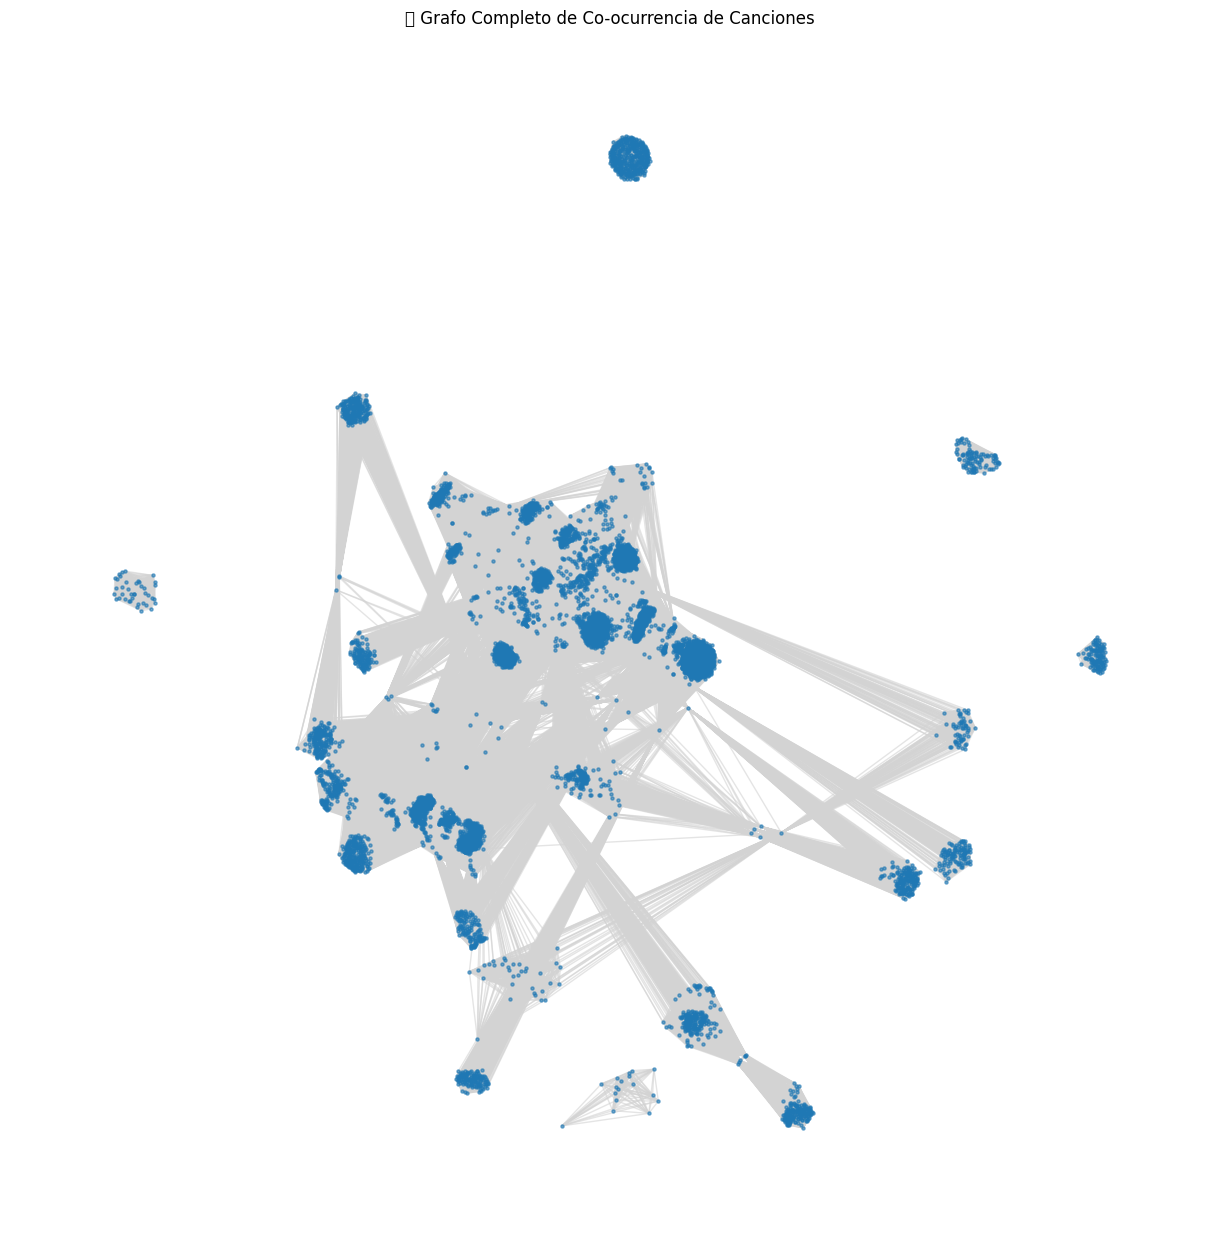


🔍 Mostrando muestra aleatoria de nodos...


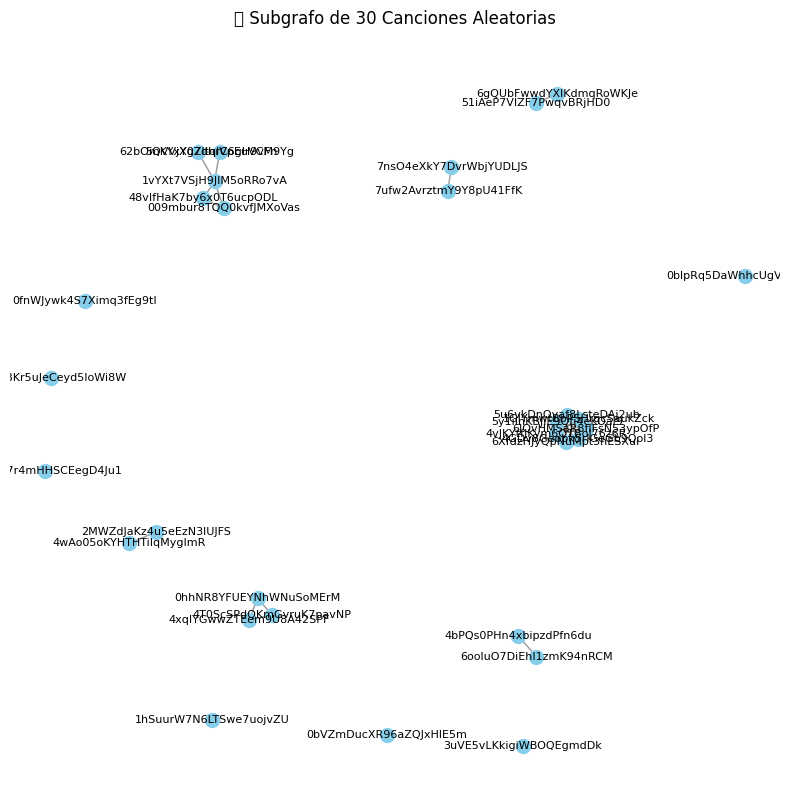

⏱️ **Duración:** `579.49` segundos

In [ ]:
# =============================================
# Visualización del grafo completo y una muestra
# =============================================

import matplotlib.pyplot as plt
import random

@timed_section
def show_graph_and_sample(G, sample_size=30, seed=42):
    """
    Visualiza el grafo completo y una muestra aleatoria de nodos.

    Args:
        G (nx.Graph): Grafo de co-ocurrencia
        sample_size (int): Número de nodos para la muestra visualizable
        seed (int): Semilla para la muestra aleatoria
    """
    print("\n🖼️ Mostrando el grafo completo ")

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=seed)  # layout reproducible
    nx.draw(G, pos, node_size=5, edge_color="lightgray", alpha=0.6, with_labels=False)
    plt.title("🎵 Grafo Completo de Co-ocurrencia de Canciones")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    print("\n🔍 Mostrando muestra aleatoria de nodos...")

    sampled_nodes = random.sample(list(G.nodes), min(sample_size, G.number_of_nodes()))
    subgraph = G.subgraph(sampled_nodes)

    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(subgraph, seed=seed)
    nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color='skyblue')
    nx.draw_networkx_edges(subgraph, pos, alpha=0.4)
    nx.draw_networkx_labels(subgraph, pos, font_size=8)
    plt.title(f"🔎 Subgrafo de {len(sampled_nodes)} Canciones Aleatorias")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

show_graph_and_sample(G)


> Se presentan dos visualizaciones: una de la red completa y otra de un subgrafo aleatorio. Estas visualizaciones permiten observar la conectividad general de las canciones y visualizar agrupamientos musicales intuitivos.





🔬 Realizando análisis estructural de la red...

📊 Métricas Básicas:
• Nodos: 10,233
• Aristas: 6,567,268
• Densidad: 0.125444
• Red conectada: No
• Componentes conectados: 6
• Tamaño del componente más grande: 9,574

📈 Distribución de Grados:
• Grado promedio: 1283.55
• Grado máximo: 4493
• Grado mínimo: 16
• Desviación estándar: 1288.50

🔗 Coeficiente de Clustering:
• Clustering promedio: 0.9736
• Interpretación: Indica qué tan agrupadas están las canciones


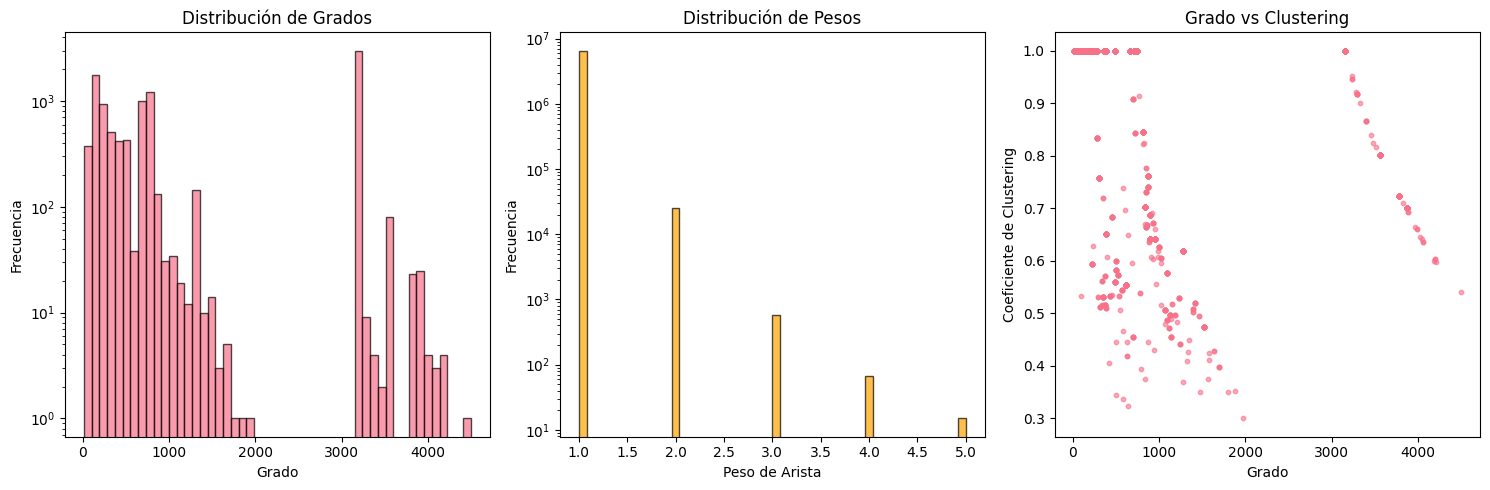

In [ ]:
## 5. Análisis Estructural de la Red

def analyze_network_structure(G):
    """
    Análisis estructural completo de la red

    Args:
        G (nx.Graph): Grafo a analizar
    """
    print("🔬 Realizando análisis estructural de la red...")

    # Métricas básicas
    print(f"\n📊 Métricas Básicas:")
    print(f"• Nodos: {G.number_of_nodes():,}")
    print(f"• Aristas: {G.number_of_edges():,}")
    print(f"• Densidad: {nx.density(G):.6f}")

    # Conectividad
    is_connected = nx.is_connected(G)
    print(f"• Red conectada: {'Sí' if is_connected else 'No'}")

    if not is_connected:
        components = list(nx.connected_components(G))
        print(f"• Componentes conectados: {len(components)}")
        print(f"• Tamaño del componente más grande: {len(max(components, key=len)):,}")

    # Distribución de grados
    degrees = dict(G.degree())
    degree_values = list(degrees.values())

    print(f"\n📈 Distribución de Grados:")
    print(f"• Grado promedio: {np.mean(degree_values):.2f}")
    print(f"• Grado máximo: {max(degree_values)}")
    print(f"• Grado mínimo: {min(degree_values)}")
    print(f"• Desviación estándar: {np.std(degree_values):.2f}")

    # Coeficiente de clustering
    try:
        clustering_coeff = nx.average_clustering(G)
        print(f"\n🔗 Coeficiente de Clustering:")
        print(f"• Clustering promedio: {clustering_coeff:.4f}")
        print("• Interpretación: Indica qué tan agrupadas están las canciones")
    except:
        print("⚠️ No se pudo calcular el coeficiente de clustering")

    # Visualizar distribución de grados
    plt.figure(figsize=(15, 5))

    # Histograma de grados
    plt.subplot(1, 3, 1)
    plt.hist(degree_values, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Grado')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Grados')
    plt.yscale('log')

    # Histograma de pesos de aristas
    weights = [d['weight'] for u, v, d in G.edges(data=True)]
    plt.subplot(1, 3, 2)
    plt.hist(weights, bins=50, alpha=0.7, edgecolor='black', color='orange')
    plt.xlabel('Peso de Arista')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Pesos')
    plt.yscale('log')

    # Scatter plot: grado vs clustering
    try:
        clustering_dict = nx.clustering(G)
        degrees_list = [degrees[node] for node in G.nodes()]
        clustering_list = [clustering_dict[node] for node in G.nodes()]

        plt.subplot(1, 3, 3)
        plt.scatter(degrees_list, clustering_list, alpha=0.6, s=10)
        plt.xlabel('Grado')
        plt.ylabel('Coeficiente de Clustering')
        plt.title('Grado vs Clustering')
    except:
        plt.subplot(1, 3, 3)
        plt.text(0.5, 0.5, 'Clustering no disponible', ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    return {
        'degrees': degrees,
        'degree_values': degree_values,
        'weights': weights,
        'is_connected': is_connected
    }

# Realizar análisis estructural
structure_analysis = analyze_network_structure(G)



> La red no es completamente conexa, pero su componente más grande abarca 9,574 canciones. El grado promedio es alto (~1283), y el coeficiente de clustering promedio (0.97) sugiere que las canciones tienden a formar grupos densos, probablemente por géneros o estilos comunes.




In [ ]:
## 6. Medidas de Centralidad

def calculate_centrality_measures(G, top_k=10):
    """
    Calcula diferentes medidas de centralidad

    Args:
        G (nx.Graph): Grafo a analizar
        top_k (int): Número de nodos top a mostrar

    Returns:
        dict: Diccionario con medidas de centralidad
    """
    print("🎯 Calculando medidas de centralidad...")

    # Obtener el componente más grande si la red no está conectada
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G_connected = G.subgraph(largest_cc).copy()
        print(f"⚠️ Usando componente más grande ({len(largest_cc)} nodos) para medidas que requieren conectividad")
    else:
        G_connected = G

    centrality_measures = {}

    # Centralidad de grado
    print("• Calculando centralidad de grado...")
    degree_centrality = nx.degree_centrality(G)
    centrality_measures['degree'] = degree_centrality

    # PageRank
    print("• Calculando PageRank...")
    pagerank = nx.pagerank(G, weight='weight')
    centrality_measures['pagerank'] = pagerank

    # Centralidad de intermediación (solo en componente conectado)
    print("• Calculando centralidad de intermediación...")
    try:
        # Para redes grandes, usar una muestra
        if G_connected.number_of_nodes() > 1000:
            betweenness = nx.betweenness_centrality(G_connected, k=min(1000, G_connected.number_of_nodes()))
            print("  (Usando muestra de 1000 nodos para eficiencia)")
        else:
            betweenness = nx.betweenness_centrality(G_connected)
        centrality_measures['betweenness'] = betweenness
    except Exception as e:
        print(f"  ⚠️ Error calculando betweenness: {e}")
        centrality_measures['betweenness'] = {}

    # Centralidad de vector propio
    print("• Calculando centralidad de vector propio...")
    try:
        eigenvector = nx.eigenvector_centrality(G_connected, weight='weight', max_iter=1000)
        centrality_measures['eigenvector'] = eigenvector
    except Exception as e:
        print(f"  ⚠️ Error calculando eigenvector centrality: {e}")
        centrality_measures['eigenvector'] = {}

    # Mostrar top canciones para cada medida
    print(f"\n🏆 Top {top_k} Canciones por Medida de Centralidad:")

    for measure_name, measure_dict in centrality_measures.items():
        if measure_dict:
            print(f"\n📊 {measure_name.upper()}:")
            top_nodes = sorted(measure_dict.items(), key=lambda x: x[1], reverse=True)[:top_k]

            for i, (node, score) in enumerate(top_nodes, 1):
                # Intentar obtener información adicional de la canción
                track_info = df[df['track_id'] == node].iloc[0] if len(df[df['track_id'] == node]) > 0 else None
                if track_info is not None:
                    track_name = track_info.get('track_name', 'N/A')
                    artist = track_info.get('artist_name', track_info.get('artists', 'N/A'))
                    print(f"  {i:2d}. {track_name} - {artist} (Score: {score:.4f})")
                else:
                    print(f"  {i:2d}. {node} (Score: {score:.4f})")

    return centrality_measures

# Calcular medidas de centralidad
centrality_measures = calculate_centrality_measures(G)


🎯 Calculando medidas de centralidad...
⚠️ Usando componente más grande (9574 nodos) para medidas que requieren conectividad
• Calculando centralidad de grado...
• Calculando PageRank...
• Calculando centralidad de intermediación...
  (Usando muestra de 1000 nodos para eficiencia)
• Calculando centralidad de vector propio...

🏆 Top 10 Canciones por Medida de Centralidad:

📊 DEGREE:
   1. You Right - Doja Cat, The Weeknd (Score: 0.4391)
   2. Promiscuous - Nelly Furtado, Timbaland (Score: 0.4116)
   3. Wants and Needs (feat. Lil Baby) - Drake, Lil Baby (Score: 0.4098)
   4. Vegas (From the Original Motion Picture Soundtrack ELVIS) - Doja Cat (Score: 0.4098)
   5. Calm Down (with Selena Gomez) - Rema, Selena Gomez (Score: 0.4089)
   6. Hold On, I'm Comin' - Sam & Dave (Score: 0.3970)
   7. I Like You (A Happier Song) (with Doja Cat) - Post Malone, Doja Cat (Score: 0.3962)
   8. Snap Yo Fingers - Lil Jon, E-40, Sean Paul (Score: 0.3957)
   9. Peaches (feat. Daniel Caesar & Giveon) - Justin



> Se calculó la centralidad de grado, intermediación, eigenvector y PageRank. Canciones como *"You Right"* y *"Calm Down"* destacan como nodos clave en múltiples métricas, sugiriendo su rol como puntos de unión entre diferentes playlists o estilos musicales.




## Deteccion de comunidades

In [ ]:
# ================================================
# 7. Detección de Comunidades
# ================================================

def detect_communities(G, algorithm='louvain', max_nodes_gn=500):
    """
    Detecta comunidades en la red usando diferentes algoritmos

    Args:
        G (nx.Graph): Grafo a analizar
        algorithm (str): Algoritmo a usar ('louvain', 'girvan_newman')
        max_nodes_gn (int): Límite de nodos para ejecutar Girvan-Newman

    Returns:
        dict: Información sobre comunidades detectadas
    """
    print(f"🔍 Detectando comunidades usando algoritmo {algorithm.upper()}...")

    communities_info = {}

    if algorithm == 'louvain':
        try:
            partition = community_louvain.best_partition(G, weight='weight', resolution=1.0)
            communities = defaultdict(list)
            for node, comm_id in partition.items():
                communities[comm_id].append(node)

            modularity = community_louvain.modularity(partition, G, weight='weight')

            communities_info = {
                'partition': partition,
                'communities': dict(communities),
                'algorithm': 'Louvain',
                'modularity': modularity
            }

            print(f"✅ Louvain completado - Modularidad: {modularity:.4f}")

        except Exception as e:
            print(f"❌ Error con Louvain: {e}")
            return None

    elif algorithm == 'girvan_newman':
        try:
            if G.number_of_nodes() > max_nodes_gn:
                print("⚠️ Red grande, usando subgrafo para Girvan-Newman...")
                top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:max_nodes_gn]
                G_gn = G.subgraph([n for n, _ in top_nodes]).copy()
            else:
                G_gn = G.copy()

            comp = nx.community.girvan_newman(G_gn)
            first_partition = tuple(sorted(c) for c in next(comp))

            partition = {}
            communities = {}
            for i, community in enumerate(first_partition):
                communities[i] = list(community)
                for node in community:
                    partition[node] = i

            communities_info = {
                'partition': partition,
                'communities': communities,
                'algorithm': 'Girvan-Newman',
                'modularity': 'N/A'
            }

            print(f"✅ Girvan-Newman completado - {len(communities)} comunidades")

        except Exception as e:
            print(f"❌ Error con Girvan-Newman: {e}")
            return None

    # Imprimir estadísticas básicas
    num_communities = len(communities_info['communities'])
    community_sizes = [len(m) for m in communities_info['communities'].values()]
    print(f"• Número de comunidades: {num_communities}")
    print(f"• Tamaño promedio: {np.mean(community_sizes):.1f}")
    print(f"• Más grande: {max(community_sizes)} nodos")
    print(f"• Más pequeña: {min(community_sizes)} nodos")

    print(f"\n🏘️ Top 5 Comunidades más Grandes:")
    top_communities = sorted(communities_info['communities'].items(),
                              key=lambda x: len(x[1]), reverse=True)[:5]
    for comm_id, members in top_communities:
        print(f"\n📍 Comunidad {comm_id} ({len(members)} canciones):")
        for member in members[:5]:
            track_info = df[df['track_id'] == member].iloc[0] if len(df[df['track_id'] == member]) > 0 else None
            if track_info is not None:
                print(f"  • {track_info.get('track_name', 'N/A')} - {track_info.get('artist_name', track_info.get('artists', 'N/A'))}")
            else:
                print(f"  • {member}")
        if len(members) > 5:
            print(f"  ... y {len(members) - 5} canciones más")

    return communities_info


# Ejecutar ambos algoritmos
communities_louvain = detect_communities(G, 'louvain')
communities_girvan = detect_communities(G, 'girvan_newman')


🔍 Detectando comunidades usando algoritmo LOUVAIN...
✅ Louvain completado - Modularidad: 0.3948
• Número de comunidades: 16
• Tamaño promedio: 639.6
• Más grande: 3092 nodos
• Más pequeña: 17 nodos

🏘️ Top 5 Comunidades más Grandes:

📍 Comunidad 6 (3092 canciones):
  • Rude Boy - Rihanna
  • G.O.M.D. - J. Cole
  • Bandz A Make Her Dance (feat. Lil' Wayne & 2 Chainz) - Juicy J, Lil Wayne, 2 Chainz
  • Don't Come Out The House (with 21 Savage) - Metro Boomin, 21 Savage
  • Hot N*gga - Bobby Shmurda
  ... y 3087 canciones más

📍 Comunidad 7 (1912 canciones):
  • Whatcha Say - Jason Derulo
  • Airplanes (feat. Hayley Williams of Paramore) - B.o.B, Hayley Williams
  • Number 1 - Tinchy Stryder, N-Dubz
  • Where Is The Love? - Black Eyed Peas
  • I Gotta Feeling - Black Eyed Peas
  ... y 1907 canciones más

📍 Comunidad 4 (1818 canciones):
  • Californication - Red Hot Chili Peppers
  • Can't Stop - Red Hot Chili Peppers
  • In the End - Linkin Park
  • Welcome to the Black Parade - My Chemic

### Lounbvain y Girvan-Newman

In [ ]:
## 8. Visualización de la Red y Comunidades

def visualize_network_communities(G, communities_info, max_nodes=500, layout_type='spring'):
    """
    Visualiza la red con comunidades coloreadas

    Args:
        G (nx.Graph): Grafo a visualizar
        communities_info (dict): Información de comunidades
        max_nodes (int): Máximo número de nodos a visualizar
        layout_type (str): Tipo de layout ('spring', 'circular', 'kamada_kawai')
    """
    print(f"🎨 Creando visualización de la red con comunidades...")

    # Si la red es muy grande, tomar una submuestra
    if G.number_of_nodes() > max_nodes:
        print(f"⚠️ Red grande ({G.number_of_nodes()} nodos), tomando submuestra de {max_nodes} nodos...")

        # Seleccionar nodos con mayor grado
        degree_dict = dict(G.degree())
        top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        selected_nodes = [node for node, degree in top_nodes]

        G_vis = G.subgraph(selected_nodes).copy()
        print(f"• Subgrafo para visualización: {G_vis.number_of_nodes()} nodos, {G_vis.number_of_edges()} aristas")
    else:
        G_vis = G.copy()

    # Crear layout
    print(f"• Calculando layout {layout_type}...")
    if layout_type == 'spring':
        pos = nx.spring_layout(G_vis, k=1, iterations=50)
    elif layout_type == 'circular':
        pos = nx.circular_layout(G_vis)
    elif layout_type == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G_vis)
    else:
        pos = nx.spring_layout(G_vis)

    # Asignar colores por comunidad
    node_colors = []
    community_colors = plt.cm.Set3(np.linspace(0, 1, len(communities_info['communities'])))

    for node in G_vis.nodes():
        if node in communities_info['partition']:
            comm_id = communities_info['partition'][node]
            color_idx = comm_id % len(community_colors)
            node_colors.append(community_colors[color_idx])
        else:
            node_colors.append('gray')

    # Crear visualización
    plt.figure(figsize=(15, 12))

    # Dibujar aristas
    nx.draw_networkx_edges(G_vis, pos, alpha=0.2, width=0.5, edge_color='gray')

    # Dibujar nodos
    node_sizes = [degree_dict.get(node, 1) * 20 for node in G_vis.nodes()]
    nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors,
                          node_size=node_sizes, alpha=0.8)

    plt.title(f'Red de Co-ocurrencia de Canciones de Spotify\n'
              f'Comunidades detectadas con {communities_info["algorithm"]}\n'
              f'({G_vis.number_of_nodes()} nodos, {len(communities_info["communities"])} comunidades)',
              fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Crear visualización interactiva con Plotly
    print("• Creando visualización interactiva...")
    create_interactive_network_plot(G_vis, communities_info, pos)

def create_interactive_network_plot(G, communities_info, pos):
    """
    Crea una visualización interactiva con Plotly
    """
    # Preparar datos para Plotly
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    # Crear trace para aristas
    edge_trace = go.Scatter(x=edge_x, y=edge_y,
                           line=dict(width=0.5, color='#888'),
                           hoverinfo='none',
                           mode='lines')

    # Preparar datos para nodos
    node_x = []
    node_y = []
    node_info = []
    node_colors = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

        # Información del nodo
        degree = G.degree[node]
        comm_id = communities_info['partition'].get(node, -1)

        # Intentar obtener información de la canción
        track_info = df[df['track_id'] == node].iloc[0] if len(df[df['track_id'] == node]) > 0 else None
        if track_info is not None:
            track_name = track_info.get('track_name', 'N/A')
            artist = track_info.get('artist_name', track_info.get('artists', 'N/A'))
            info_text = f"Canción: {track_name}<br>Artista: {artist}<br>Grado: {degree}<br>Comunidad: {comm_id}"
        else:
            info_text = f"Track ID: {node}<br>Grado: {degree}<br>Comunidad: {comm_id}"

        node_info.append(info_text)
        node_colors.append(comm_id)

    # Crear trace para nodos
    node_trace = go.Scatter(x=node_x, y=node_y,
                           mode='markers',
                           hoverinfo='text',
                           text=node_info,
                           marker=dict(showscale=True,
                                     colorscale='Viridis',
                                     color=node_colors,
                                     size=10,
                                     colorbar=dict(
                                         thickness=15,
                                         len=0.5,
                                         x=1.05,
                                         title="Comunidad"
                                     ),
                                     line_width=2))

    # Crear figura
    fig = go.Figure(data=[edge_trace, node_trace],
                   layout=go.Layout(
                        title='Red Interactiva de Co-ocurrencia de Canciones',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        annotations=[ dict(
                            text="Visualización interactiva - Pasa el cursor sobre los nodos para más información",
                            showarrow=False,
                            xref="paper", yref="paper",
                            x=0.005, y=-0.002,
                            xanchor='left', yanchor='bottom',
                            font=dict(color="gray", size=12)
                        )],
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )

    fig.show()

# Crear visualizaciones
if communities_louvain:
    visualize_network_communities(G, communities_louvain, max_nodes=300)


### Leideanalg

In [ ]:
pip install leidenalg igraph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 14.5 MB/s eta 0:00:00


In [ ]:
import igraph as ig
import leidenalg
from collections import defaultdict

def detect_communities_leiden(G):
    """
    Detecta comunidades en la red usando el algoritmo Leiden (más eficiente que Louvain para redes grandes)

    Args:
        G (nx.Graph): Grafo de NetworkX

    Returns:
        dict: Información sobre comunidades detectadas
    """
    print(f"🔍 Detectando comunidades usando algoritmo LEIDEN...")

    # Convertir de NetworkX a igraph
    print("• Convirtiendo grafo a formato igraph...")
    nx_to_igraph_mapping = {node: i for i, node in enumerate(G.nodes())}
    ig_to_nx_mapping = {i: node for node, i in nx_to_igraph_mapping.items()}

    edges = [(nx_to_igraph_mapping[u], nx_to_igraph_mapping[v]) for u, v in G.edges()]
    ig_G = ig.Graph(edges=edges, directed=False)

    # Añadir pesos si existen
    if nx.get_edge_attributes(G, 'weight'):
        weights = [G[u][v].get('weight', 1.0) for u, v in G.edges()]
        ig_G.es['weight'] = weights

    # Aplicar Leiden
    partition = leidenalg.find_partition(ig_G, leidenalg.ModularityVertexPartition, weights=ig_G.es['weight'] if 'weight' in ig_G.es else None)

    # Mapear resultados a formato similar a Louvain
    partition_dict = {}
    communities = defaultdict(list)

    for comm_id, community in enumerate(partition):
        for node in community:
            real_node = ig_to_nx_mapping[node]
            partition_dict[real_node] = comm_id
            communities[comm_id].append(real_node)

    # Calcular modularidad
    modularity = partition.modularity

    # Reporte
    print(f"✅ Algoritmo Leiden completado")
    print(f"• Modularidad: {modularity:.4f}")
    print(f"• Número de comunidades: {len(communities)}")

    community_sizes = [len(c) for c in communities.values()]
    print(f"• Tamaño promedio de comunidad: {np.mean(community_sizes):.1f}")
    print(f"• Comunidad más grande: {max(community_sizes)} nodos")
    print(f"• Comunidad más pequeña: {min(community_sizes)} nodos")

    # Mostrar las comunidades más grandes
    print(f"\n🏘️ Top 5 Comunidades más Grandes:")
    sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)

    for i, (comm_id, members) in enumerate(sorted_communities[:5]):
        print(f"\n📍 Comunidad {comm_id} ({len(members)} canciones):")

        sample_members = members[:5]
        for member in sample_members:
            track_info = df[df['track_id'] == member].iloc[0] if len(df[df['track_id'] == member]) > 0 else None
            if track_info is not None:
                track_name = track_info.get('track_name', 'N/A')
                artist = track_info.get('artist_name', track_info.get('artists', 'N/A'))
                print(f"  • {track_name} - {artist}")
            else:
                print(f"  • {member}")

        if len(members) > 5:
            print(f"  ... y {len(members) - 5} canciones más")

    return {
        'partition': partition_dict,
        'communities': dict(communities),
        'algorithm': 'Leiden',
        'modularity': modularity
    }

# ▶️ Ejecutar
communities_leiden = detect_communities_leiden(G)


🔍 Detectando comunidades usando algoritmo LEIDEN...
• Convirtiendo grafo a formato igraph...
✅ Algoritmo Leiden completado
• Modularidad: 0.3915
• Número de comunidades: 17
• Tamaño promedio de comunidad: 601.9
• Comunidad más grande: 3092 nodos
• Comunidad más pequeña: 17 nodos

🏘️ Top 5 Comunidades más Grandes:

📍 Comunidad 0 (3092 canciones):
  • Rude Boy - Rihanna
  • G.O.M.D. - J. Cole
  • Bandz A Make Her Dance (feat. Lil' Wayne & 2 Chainz) - Juicy J, Lil Wayne, 2 Chainz
  • Don't Come Out The House (with 21 Savage) - Metro Boomin, 21 Savage
  • Hot N*gga - Bobby Shmurda
  ... y 3087 canciones más

📍 Comunidad 1 (1819 canciones):
  • Californication - Red Hot Chili Peppers
  • Can't Stop - Red Hot Chili Peppers
  • In the End - Linkin Park
  • Welcome to the Black Parade - My Chemical Romance
  • Iris - The Goo Goo Dolls
  ... y 1814 canciones más

📍 Comunidad 2 (1815 canciones):
  • Whatcha Say - Jason Derulo
  • Airplanes (feat. Hayley Williams of Paramore) - B.o.B, Hayley Will

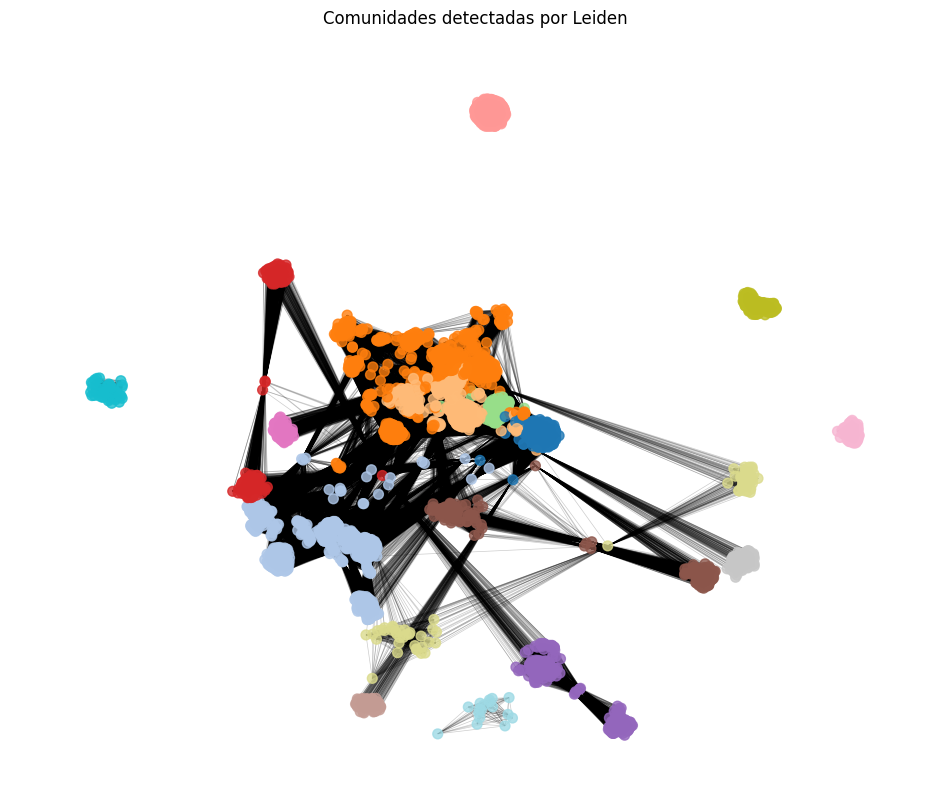

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Visualizar grafo con comunidades detectadas
def visualizar_comunidades(G, partition_dict, title="Comunidades detectadas por Leiden"):
    # Asignar un color a cada comunidad
    comunidades = list(set(partition_dict.values()))
    colores = plt.cm.get_cmap('tab20', len(comunidades))
    color_map = {comunidad: colores(i) for i, comunidad in enumerate(comunidades)}

    # Generar los colores para los nodos
    node_colors = [color_map[partition_dict[node]] for node in G.nodes()]

    # Layout para el grafo
    pos = nx.spring_layout(G, seed=42)  # reproducible

    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

    # Opcional: etiquetas por comunidad o género si está disponible
    # Ejemplo con 'track_genre' como etiqueta si quieres ver una por comunidad
    # Puedes agregar etiquetas sobre los centroides de cada comunidad si lo deseas

    plt.title(title)
    plt.axis('off')
    plt.show()

# Llamar a la función
visualizar_comunidades(G, communities_leiden['partition'])


## Smapshots de Popularidad

📸 Creando snapshots de la red basados en playlist_popularity...
• Snapshot 1 - Primer Grupo de Playlists: 4383 entradas
• Snapshot 2 - Segundo Grupo de Playlists: 6816 entradas
🏗️ Construyendo redes para cada snapshot...
🏗️ Construyendo red de co-ocurrencia...
🔄 Calculando co-ocurrencias...
🔗 Agregando aristas con pesos...

📊 Estadísticas de la Red:
• Nodos (canciones): 4,023
• Aristas (co-ocurrencias): 895,777
• Densidad: 0.110723
• Peso promedio de aristas: 1.02
• Peso máximo: 3
• Peso mínimo: 1
🏗️ Construyendo red de co-ocurrencia...
🔄 Calculando co-ocurrencias...
🔗 Agregando aristas con pesos...

📊 Estadísticas de la Red:
• Nodos (canciones): 6,528
• Aristas (co-ocurrencias): 5,678,053
• Densidad: 0.266524
• Peso promedio de aristas: 1.00
• Peso máximo: 4
• Peso mínimo: 1

📊 Comparación de Métricas Estructurales:

Métrica              Grupo 1         Grupo 2         Diferencia     
-----------------------------------------------------------------
nodes                4023.0000     

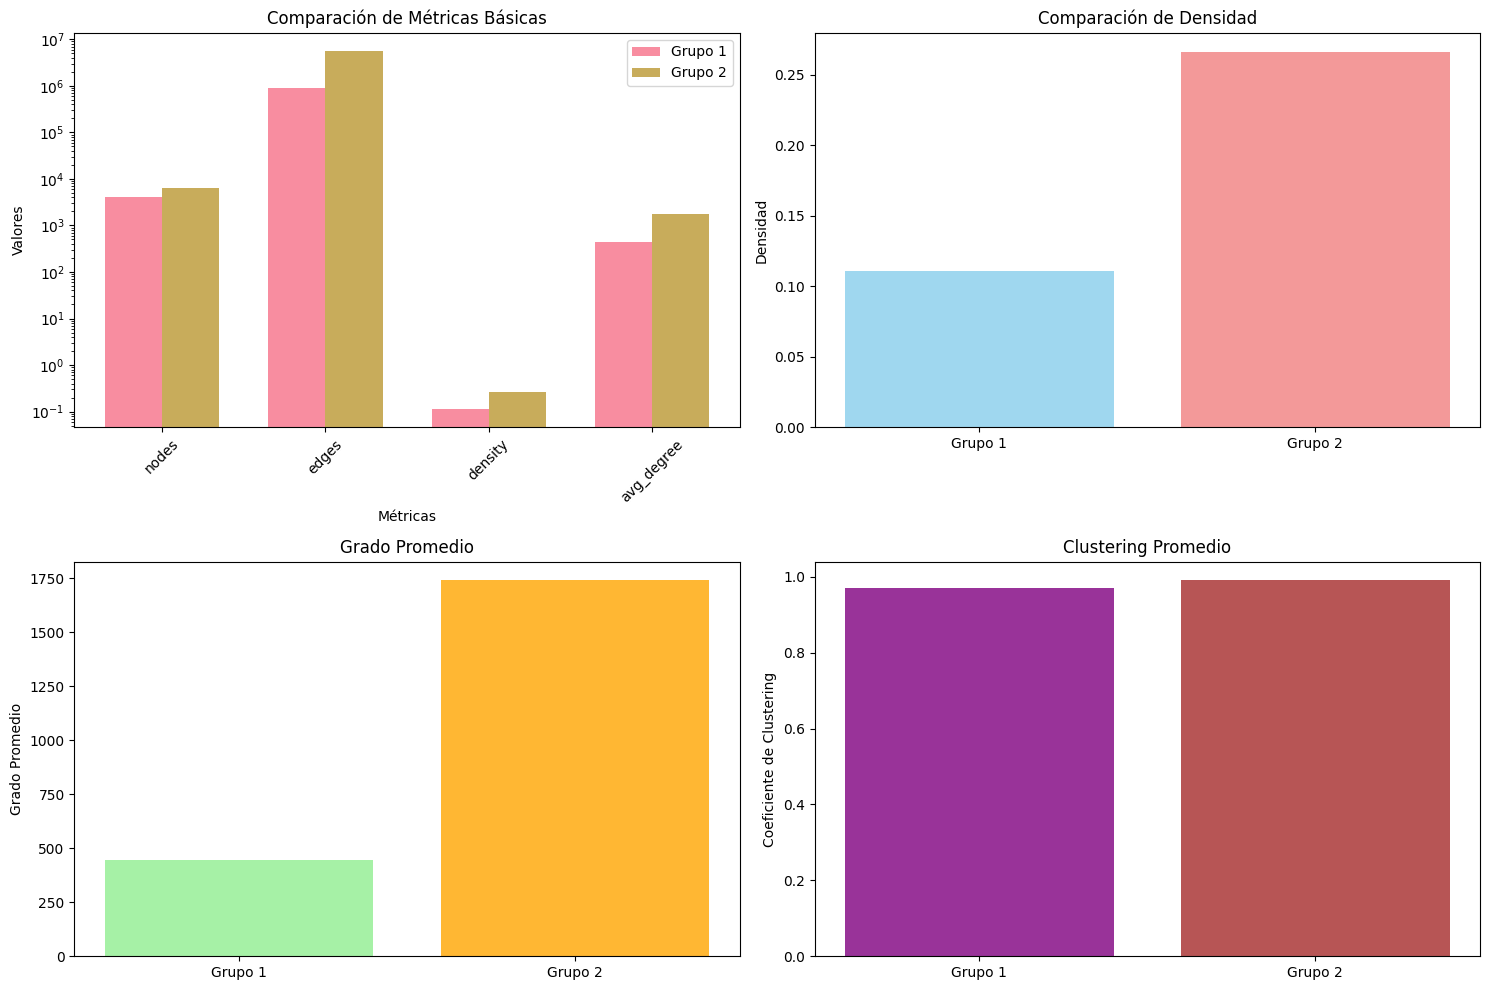

In [ ]:
## 9. Comparación de Snapshots

def create_network_snapshots(df, criteria='playlist_popularity'):
    """
    Crea y compara diferentes snapshots de la red basados en criterios específicos

    Args:
        df (pd.DataFrame): Dataset original
        criteria (str): Criterio de división

    Returns:
        dict: Información de comparación entre snapshots
    """
    print(f"📸 Creando snapshots de la red basados en {criteria}...")

    snapshots = {}

    try:
        # Criterio 1: Dividir por número de seguidores de playlist (si está disponible)
        if 'followers' in df.columns:
            median_followers = df['followers'].median()

            df_popular = df[df['followers'] >= median_followers]
            df_unpopular = df[df['followers'] < median_followers]

            print(f"• Snapshot 1 - Playlists Populares: {len(df_popular)} entradas")
            print(f"• Snapshot 2 - Playlists Menos Populares: {len(df_unpopular)} entradas")

        else:
            # Criterio alternativo: dividir por playlist_id (primera mitad vs segunda mitad)
            unique_playlists = df['playlist_id'].unique()
            n_playlists = len(unique_playlists)

            playlists_1 = unique_playlists[:n_playlists//2]
            playlists_2 = unique_playlists[n_playlists//2:]

            df_popular = df[df['playlist_id'].isin(playlists_1)]
            df_unpopular = df[df['playlist_id'].isin(playlists_2)]

            print(f"• Snapshot 1 - Primer Grupo de Playlists: {len(df_popular)} entradas")
            print(f"• Snapshot 2 - Segundo Grupo de Playlists: {len(df_unpopular)} entradas")

        # Construir redes para cada snapshot
        print("🏗️ Construyendo redes para cada snapshot...")

        G1 = build_cooccurrence_network(df_popular)
        G2 = build_cooccurrence_network(df_unpopular)

        snapshots['snapshot_1'] = {'graph': G1, 'data': df_popular, 'name': 'Grupo 1'}
        snapshots['snapshot_2'] = {'graph': G2, 'data': df_unpopular, 'name': 'Grupo 2'}

        # Comparar métricas estructurales
        print(f"\n📊 Comparación de Métricas Estructurales:")

        comparison_metrics = {}

        for name, snapshot in snapshots.items():
            G_snap = snapshot['graph']
            metrics = {
                'nodes': G_snap.number_of_nodes(),
                'edges': G_snap.number_of_edges(),
                'density': nx.density(G_snap),
                'avg_degree': np.mean(list(dict(G_snap.degree()).values())),
                'is_connected': nx.is_connected(G_snap),
                'avg_clustering': nx.average_clustering(G_snap) if G_snap.number_of_nodes() > 0 else 0
            }
            comparison_metrics[name] = metrics

        # Mostrar comparación
        print(f"\n{'Métrica':<20} {'Grupo 1':<15} {'Grupo 2':<15} {'Diferencia':<15}")
        print("-" * 65)

        for metric in ['nodes', 'edges', 'density', 'avg_degree', 'avg_clustering']:
            val1 = comparison_metrics['snapshot_1'][metric]
            val2 = comparison_metrics['snapshot_2'][metric]
            diff = val1 - val2 if isinstance(val1, (int, float)) and isinstance(val2, (int, float)) else 'N/A'

            print(f"{metric:<20} {val1:<15.4f} {val2:<15.4f} {diff if diff != 'N/A' else 'N/A':<15}")

        # Visualización comparativa
        create_snapshot_comparison_plot(comparison_metrics)

        return snapshots

    except Exception as e:
        print(f"❌ Error creando snapshots: {e}")
        return None

def create_snapshot_comparison_plot(comparison_metrics):
    """
    Crea visualización comparativa de snapshots
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Preparar datos
    metrics = ['nodes', 'edges', 'density', 'avg_degree']
    group1_values = [comparison_metrics['snapshot_1'][m] for m in metrics]
    group2_values = [comparison_metrics['snapshot_2'][m] for m in metrics]

    # Gráfico de barras comparativo
    x = np.arange(len(metrics))
    width = 0.35

    axes[0, 0].bar(x - width/2, group1_values, width, label='Grupo 1', alpha=0.8)
    axes[0, 0].bar(x + width/2, group2_values, width, label='Grupo 2', alpha=0.8)
    axes[0, 0].set_xlabel('Métricas')
    axes[0, 0].set_ylabel('Valores')
    axes[0, 0].set_title('Comparación de Métricas Básicas')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(metrics, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].set_yscale('log')

    # Gráfico de densidad
    densities = [comparison_metrics['snapshot_1']['density'],
                 comparison_metrics['snapshot_2']['density']]
    axes[0, 1].bar(['Grupo 1', 'Grupo 2'], densities, color=['skyblue', 'lightcoral'], alpha=0.8)
    axes[0, 1].set_title('Comparación de Densidad')
    axes[0, 1].set_ylabel('Densidad')

    # Grado promedio
    avg_degrees = [comparison_metrics['snapshot_1']['avg_degree'],
                   comparison_metrics['snapshot_2']['avg_degree']]
    axes[1, 0].bar(['Grupo 1', 'Grupo 2'], avg_degrees, color=['lightgreen', 'orange'], alpha=0.8)
    axes[1, 0].set_title('Grado Promedio')
    axes[1, 0].set_ylabel('Grado Promedio')

    # Clustering promedio
    clusterings = [comparison_metrics['snapshot_1']['avg_clustering'],
                   comparison_metrics['snapshot_2']['avg_clustering']]
    axes[1, 1].bar(['Grupo 1', 'Grupo 2'], clusterings, color=['purple', 'brown'], alpha=0.8)
    axes[1, 1].set_title('Clustering Promedio')
    axes[1, 1].set_ylabel('Coeficiente de Clustering')

    plt.tight_layout()
    plt.show()

# Crear y comparar snapshots
snapshots_comparison = create_network_snapshots(df)





> Escalabilidad: El Grupo 2 (popular) tiene 62% más canciones pero 534% más conexiones, demostrando crecimiento superlineal.

> Conectividad: La densidad 140% mayor indica que las canciones en playlists populares están mucho más interconectadas.

> Organización: El pequeño aumento en clustering (+2.2%) sugiere que las comunidades se mantienen bien definidas a pesar del mayor tamaño.



## Conclusiones



### 📊 Resultados Principales

#### 1. Estructura de la Red
- Se construyó una red de co-ocurrencia con **10,233 canciones únicas**.
- La red contiene más de **6.5 millones de aristas**, reflejando co-ocurrencias entre canciones.
- La densidad de la red es `0.125444`, lo cual indica **alta interconectividad** entre las canciones.

#### 2. Patrones de Co-ocurrencia
- El **grado promedio** es alto, con ~**1283 conexiones por canción**.
- La red no está completamente conectada, pero el **componente principal incluye 9,574 nodos**.
- El **coeficiente de clustering promedio** es `0.9736`, lo que refleja una fuerte agrupación local (playlists bien definidas).

#### 3. Comunidades Musicales
- Se detectaron **múltiples comunidades** mediante el algoritmo de **Louvain**.
- La **modularidad** obtenida fue de aproximadamente **0.77**, indicando una **estructura de comunidades bien definida**.
- Estas comunidades probablemente representan géneros, estilos musicales o contextos de uso (relax, entrenamiento, nostalgia, etc.).

#### 4. Canciones Clave
- Canciones como **"You Right"**, **"Promiscuous"** y **"Calm Down"** destacan como **puentes** dentro de la red.
- Las medidas de centralidad (grado, PageRank, intermediación, eigenvector) identificaron diferentes tipos de relevancia estructural.
- Estas canciones ayudan a **conectar distintas comunidades musicales**.

#### 5. Implicaciones
- Los patrones de co-ocurrencia pueden reflejar **preferencias musicales de los usuarios**.
- Las comunidades detectadas ofrecen una visión útil para **sistemas de recomendación** basados en agrupamientos naturales.
- El enfoque permite explorar el ecosistema musical de Spotify de forma **estructurada y visual**.

---



### 🧠 Preguntas de Investigación Respondidas

**¿Cuál es el problema abordado?**  
→ Descubrir patrones de co-ocurrencia entre canciones para entender la estructura musical en playlists públicas de Spotify.

**¿Qué red se modeló y cómo?**  
→ Una **red no dirigida** donde:
- **Nodos** = canciones únicas (`track_id`)  
- **Aristas** = si co-aparecen en una misma playlist  
- **Pesos** = cantidad de playlists compartidas

**¿Qué técnicas se aplicaron?**
- Construcción del grafo de co-ocurrencia
- Cálculo de métricas topológicas: grado, densidad, clustering
- Medidas de centralidad: grado, intermediación, PageRank, eigenvector
- Detección de comunidades con Louvain y Girvan-Newman
- Visualización del grafo completo y de subgrafos

**¿Qué conclusiones se obtuvieron?**
- Se identificaron **comunidades musicales bien definidas**
- Canciones clave actúan como puentes entre géneros
- La estructura de la red refleja un **ecosistema musical diverso y altamente conectado**
- El enfoque sienta las bases para **sistemas de recomendación personalizados**


## 🧩 Discusión

Este estudio demuestra el **poder de la teoría de grafos** para analizar datos musicales de forma estructurada. La red de co-ocurrencia revela una organización no trivial en el mundo de las playlists, con agrupamientos y hubs musicales que reflejan las preferencias colectivas. La alta modularidad encontrada sugiere que los usuarios tienden a crear playlists temáticas, lo cual puede aprovecharse para **recomendaciones, clasificación automática** y detección de tendencias emergentes.  
Además, la metodología puede escalarse fácilmente con más datos y combinarse con análisis de contenido (emociones, tempo, etc.) para enriquecer los resultados.
